# ライブラリの読み込み

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import functools # 関数を引数とする関数を使うため必要
import random
# ネットワーク分析用
import networkx as nx
from networkx.algorithms import community # コミュニティ検出に用いる
import igraph # スピングラス法が使える

関数をいくつか作成

In [179]:
# 着目する企業群node_listから，距離がdistance以内である企業を抽出
# 方向を考慮しないdistanceを考える場合，無向グラフに変換する必要あり(関数内だと時間がかかる)
def filter_neighbors(node, G, node_list, distance):
    flag = False
    for node_c in node_list:
        flag = (flag | (nx.shortest_path_length(G, source = node_c, target = node) <= distance))
    return flag

# subgraph_viewで一部引数をfixするために必要
def filter_neighbors_partial(G, node_list, distance):
    return functools.partial(filter_neighbors, G = G, node_list = node_list, distance = distance) # nodeはsubgraph_viewで使う

# ネットワークのプロット
# node_attrはノードの大きさを指定するノードの属性(MCAPなど)，width_attrはエッジの太さを指定するエッジの属性(RATIO_X_TO_Yなど)
def plot_network(G, node_attr, width_attr, color_attr, label_attr, node_focus = None, \
                    alpha = 0.5, node_scale = 20, width_scale = 15, arrowsize = 15, seed_for_plot = 1, k_scale = 2.0):
    edgecolors = "black" # ノードの縁の色
    edge_color = "dimgray" # エッジの色
    # その他の設定
    pos = nx.spring_layout(G, seed = seed_for_plot, k = k_scale / np.sqrt(G.size()), iterations = 1) # 初期位置を指定する必要あり
    if node_focus is None: # フォーカスする企業がない場合
        fixed = None
        center = None
    else:
        pos[node_focus] = np.array([0.0, 0.0]) # 中心にする
        fixed = [node_focus]
        center = np.array([0.0, 0.0])
    # kが大きい場合，ノード間の距離が遠くなる
    pos = nx.spring_layout(G, pos = pos, fixed = fixed, seed = seed_for_plot, k = k_scale / np.sqrt(G.size()), center = center)
    
    nx.draw(G, with_labels = True, pos = pos,\
        node_size = np.sqrt(np.fromiter(nx.get_node_attributes(G, node_attr).values(), dtype = float))*node_scale,  # ノードの面積
        node_color = nx.get_node_attributes(G, color_attr).values(),
        labels = nx.get_node_attributes(G, label_attr),
        width = np.fromiter(nx.get_edge_attributes(G, width_attr).values(), dtype = float)*width_scale, # エッジの太さ
        alpha = alpha, edgecolors = edgecolors, \
        edge_color = edge_color, arrowsize = arrowsize, font_family = "MS Gothic")

ユニバースの情報を取得

In [180]:
df_univ = pd.read_excel("df_univ.xlsx")
df_univ["COLOR"] = "white"
df_univ

,CODE,NAME,IND33,IND33_NAME,SIZE_CODE,SIZE,MCAP,COLOR
0,1301,極洋,50,水産・農林業,7,TOPIX Small 2,251.484793,white
1,1332,ニッスイ,50,水産・農林業,4,TOPIX Mid400,201.030688,white
2,1333,マルハニチロ,50,水産・農林業,4,TOPIX Mid400,237.240221,white
3,1375,雪国まいたけ,50,水産・農林業,7,TOPIX Small 2,25.935481,white
4,1376,カネコ種苗,50,水産・農林業,7,TOPIX Small 2,105.799271,white
...,...,...,...,...,...,...,...,...
2158,9991,ジェコス,6050,卸売業,7,TOPIX Small 2,0.503773,white
2159,9993,ヤマザワ,6100,小売業,7,TOPIX Small 2,94.119841,white
2160,9994,やまや,6100,小売業,7,TOPIX Small 2,47.934445,white
2161,9995,グローセル,6050,卸売業,7,TOPIX Small 2,645.209535,white


株式保有状況を適当に生成

In [181]:
num_stock_average = 5
df_x_to_y = df_univ[["CODE"]].sample(n = num_stock_average * len(df_univ), replace = True).rename(columns = {"CODE": "CODE_X"})
df_x_to_y["CODE_Y"] = df_univ[["CODE"]].sample(n = num_stock_average * len(df_univ), replace = True).values
df_x_to_y = df_x_to_y[df_x_to_y["CODE_X"] != df_x_to_y["CODE_Y"]].copy()
alpha, beta = 1.0, 10.0
df_x_to_y["RATIO_X_TO_Y"] = np.random.beta(alpha, beta, size = len(df_x_to_y))
df_x_to_y["MCAP_X_TO_Y"] = np.random.lognormal(mean = 3, sigma = 1, size = len(df_x_to_y))

df_x_to_y.reset_index(drop = True)

,CODE_X,CODE_Y,RATIO_X_TO_Y,MCAP_X_TO_Y
0,6459,6134,0.162120,4.437504
1,6817,1887,0.054141,27.167086
2,7718,6540,0.040171,36.375143
3,7088,6050,0.018766,23.690261
4,8230,8940,0.046046,13.088965
...,...,...,...,...
10804,7173,7202,0.059781,26.218249
10805,5464,7196,0.027240,6.828638
10806,5721,8074,0.317779,15.884698
10807,6445,2440,0.032539,18.244753


グラフを作成

In [182]:
G = nx.from_pandas_edgelist(df_x_to_y, source = "CODE_X", target = "CODE_Y",\
                            edge_attr = ["RATIO_X_TO_Y", "MCAP_X_TO_Y"], create_using = nx.DiGraph)
dict_node_attr = df_univ.set_index('CODE').to_dict('index')
nx.set_node_attributes(G, dict_node_attr)

# グラフのプロット

ある企業に注目した場合

In [183]:
CODE_FOCUS = 7203

# 関数内で処理すると時間がかかってしまう
G_undirected = G.to_undirected()
G_undirected_reciprocal = G.to_undirected(reciprocal = True)
G_focus = nx.subgraph_view(G, filter_node = filter_neighbors_partial(G = G_undirected, node_list = [CODE_FOCUS], distance = 1))
nx.set_node_attributes(G_focus, name = "COLOR", values = {CODE_FOCUS: "red"})

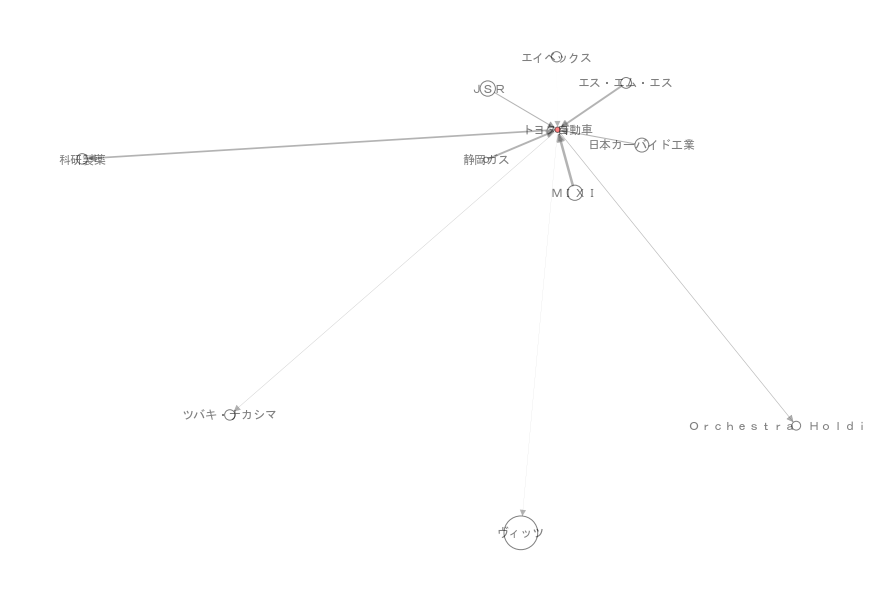

In [184]:
fig = plt.figure(figsize = (12, 8))
plot_network(G_focus, node_attr = "MCAP", width_attr = "RATIO_X_TO_Y", color_attr = "COLOR", label_attr = "NAME", node_focus = CODE_FOCUS)

検出されたコミュニティに注目する場合

In [185]:
community_list = community.greedy_modularity_communities(G_undirected)
print([len(s) for s in community_list])
idx = len(community_list) - 1
node_list = community_list[idx]
print(node_list)

[490, 458, 451, 378, 198, 103, 53, 15, 9, 8]
frozenset({1605, 9147, 1835, 4203, 9983, 8283, 5949, 9663})


In [186]:
G_focus = nx.subgraph_view(G, filter_node = filter_neighbors_partial(G = G_undirected, node_list = node_list, distance = 1))
dict_color = dict(zip(node_list, ["red" for _ in range(len(node_list))]))
nx.set_node_attributes(G_focus, name = "COLOR", values = dict_color)

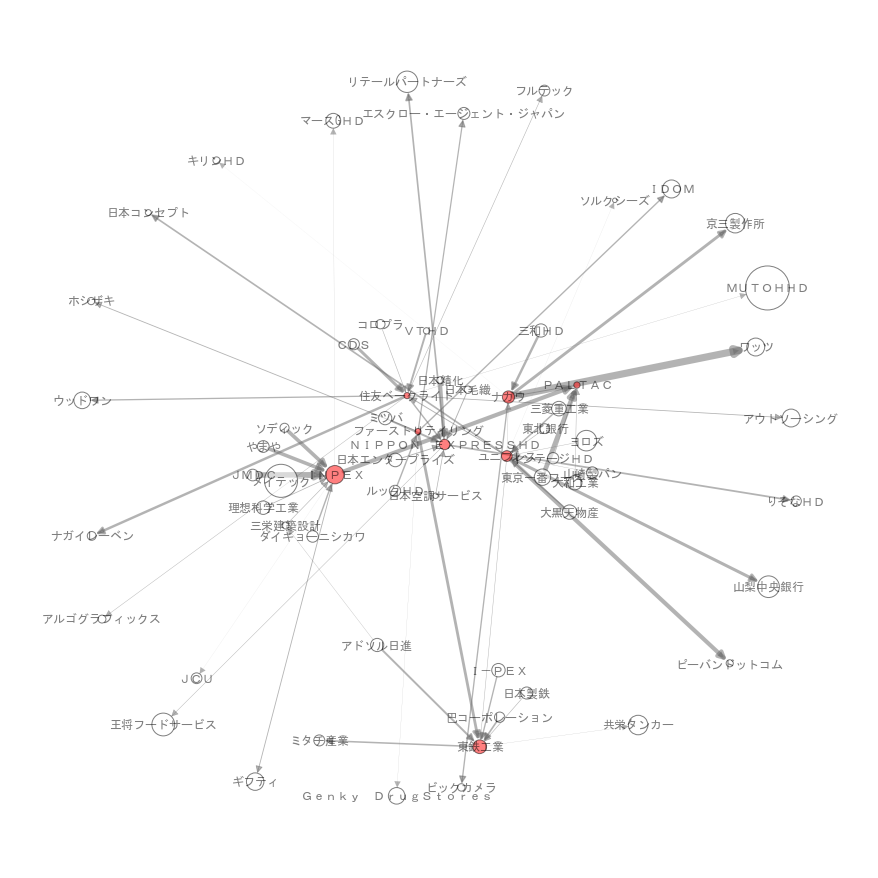

In [187]:
fig = plt.figure(figsize = (12, 12))
plot_network(G_focus, node_attr = "MCAP", width_attr = "RATIO_X_TO_Y", color_attr = "COLOR", label_attr = "NAME", k_scale = 4.0)

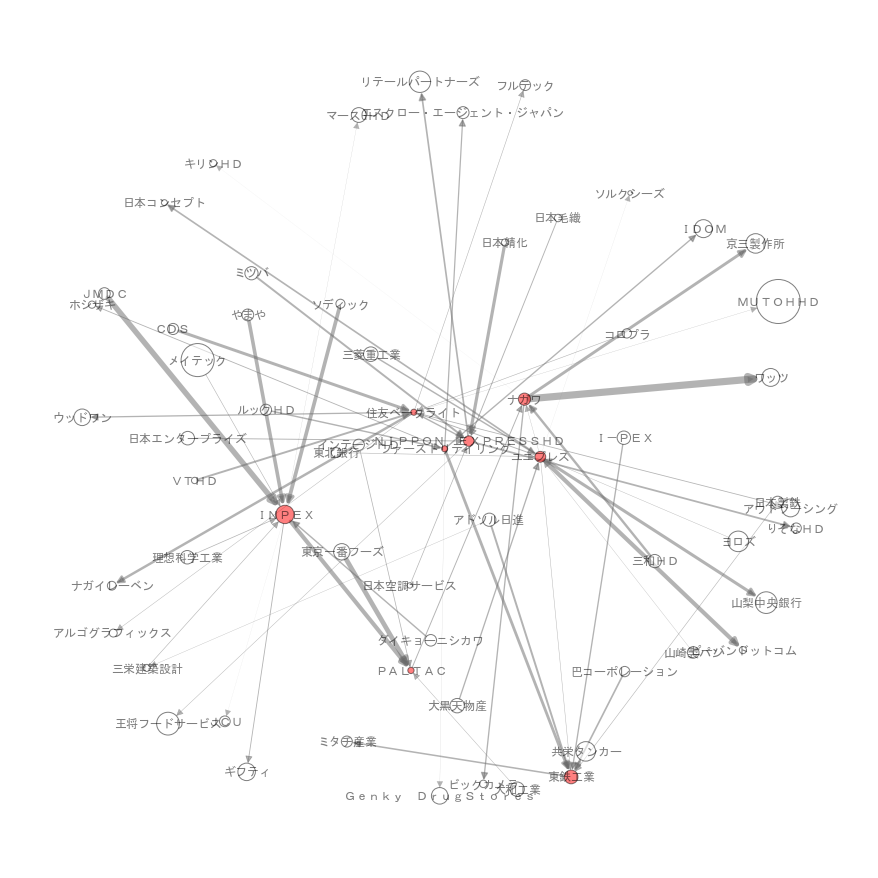

In [188]:
fig = plt.figure(figsize = (12, 12))
plot_network(G_focus, node_attr = "MCAP", width_attr = "RATIO_X_TO_Y", color_attr = "COLOR", label_attr = "NAME", k_scale = 10.0)